# Lab-03 Neural Networks

## Loading Data

In [1]:
import os
import re
import cv2

images = []
pose_name = []
images_path = []
images_pixels = []
labels = []

dict = {}

i=0
dataPath = './yogaData'

for directory in os.listdir(dataPath):
    dirPath = os.path.join(dataPath, directory)
    if os.path.isdir(dirPath):
        pose_name.append(directory)
        for img in os.listdir(dirPath):
            if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
                img_path = os.path.join(dirPath,img)
                images.append(img)
                images_path.append(img_path)
                img_pix = cv2.imread(img_path,1)
                images_pixels.append(cv2.resize(img_pix, (100,100)))
                labels.append(i)
        
    i = i+1
            
print("Total images: ", len(images))
print("Total images path: ", len(images_path))
print("Total postures: ", len(pose_name))
print("Total images_pixels: ", len(images_pixels))  

libpng warning: iCCP: known incorrect sRGB profile


Total images:  2177
Total images path:  2177
Total postures:  9
Total images_pixels:  2177


In [2]:
import random

shuffled = list(zip(images_pixels,labels))
random.shuffle(shuffled)

train_data, labels_data = zip(*shuffled)

In [3]:
from tensorflow.keras.utils import to_categorical
import numpy as np

X_data = np.array(train_data)/255
X_data = np.float32(X_data) # pytorch seems to require float32. float64 will result in a type error
Y_data =  to_categorical(labels_data, num_classes = 9)

2023-12-05 13:15:09.121994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
X_data.shape

(2177, 100, 100, 3)

## Split the Data

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
for train_indices, everything_else_indices in sss.split(X_data, Y_data):
    # print(everything_else_indices)
    train_x = X_data[train_indices]
    train_y = Y_data[train_indices]
    everything_else_x = X_data[everything_else_indices]
    everything_else_y = Y_data[everything_else_indices]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
for test_index, valid_index in sss.split(everything_else_x, everything_else_y):
    test_x = everything_else_x[test_index]
    valid_x = everything_else_x[valid_index]
    test_y = everything_else_y[test_index]
    valid_y = everything_else_y[valid_index]

In [6]:
train_x.shape

(1523, 100, 100, 3)

array([0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

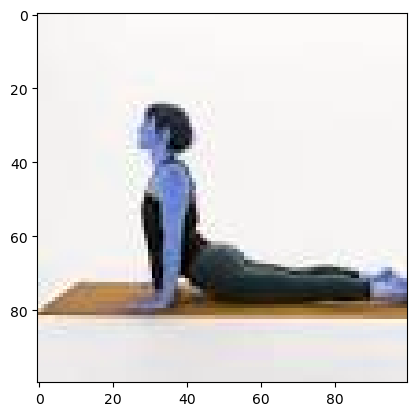

In [7]:
import matplotlib.pyplot as plt

plt.imshow(train_x[3])
train_y[3]

## Random Forest

Random forest can't handle 4D arrays. This can be worked around by reshaping ``train_x``, ``valid_x``, and ``test_x`` from (r, 100, 100, 3) to (r, 30000)

In [8]:
samples, nx, ny, rgb = train_x.shape
rf_train_x = train_x.reshape(samples, nx * ny * rgb)

samples, nx, ny, rgb = test_x.shape
rf_test_x = test_x.reshape(samples, nx * ny * rgb)

In [9]:
rf_train_x.shape

(1523, 30000)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=16, max_features='sqrt',
                            min_samples_leaf=1, min_samples_split=2, n_estimators=47, random_state=42)
rf.fit(rf_train_x, train_y)
predictions = rf.predict(rf_test_x)
accuracy_score(test_y, predictions)

0.5107033639143731

`criterion` is the function that measures the quality of a split in the tree.
`min_samples_split` is the minimum number of samples in a node to split it.
`min_samples_leaf` detremines the minimum number of samples in a leaf node.
`max_features` determines the number of features to look at when determining the best split. In this case, it is the square root of `n_features`.
`bootstrap` uses the whole dataset to build the tree rather than adding bootstrapping samples.
`random_state` predetermines randomization for reproducibility.

The random forest algorithm does not perform well, having less than 50% accuracy.

In [11]:
from sklearn.metrics import classification_report

print(classification_report(test_y, predictions, zero_division=np.nan, target_names=pose_name))

                        precision    recall  f1-score   support

     Downward-Dog-Pose       1.00      0.53      0.69        34
             Tree-Pose       0.96      0.50      0.66        50
          Warrior-Pose       1.00      0.56      0.72        32
            Cobra-Pose       1.00      0.57      0.72        30
           Pigeon-Pose       1.00      0.45      0.62        31
         Triangle-Pose       1.00      0.44      0.61        41
           Bridge-Pose       0.95      0.50      0.66        40
Standing-Mountain-Pose       1.00      0.60      0.75        30
            Child-Pose       1.00      0.49      0.66        39

             micro avg       0.99      0.51      0.67       327
             macro avg       0.99      0.52      0.68       327
          weighted avg       0.99      0.51      0.67       327
           samples avg       0.99      0.51      1.00       327



The high precision and low recall shows that while the model is bad at predicting the pose from the image, within each pose, the predictions made tend to be accurate. While the model misclassified most of the downward dog poses, all of the images that it predicted were downward dog poses were correct. The low f1-score reflects the poor performance of the model.

## Convolutional Neural Network

### DataLoader

In [12]:
from torch.utils.data import DataLoader

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_sample = self.X[idx]
        y_sample = self.Y[idx]
        
        if self.transform:
            x_sample = self.transform(x_sample)
            
        return x_sample, y_sample

Transform the image in order to convert the image into a tensor, and to normalize the values of the tensors in order to decrease skew and make the distribution of color values a normal distribution.

In [13]:
from torchvision import transforms

img_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the values of the image
])

In [14]:
train = CustomDataset(train_x, train_y, transform=img_transform)
val = CustomDataset(valid_x, valid_y, transform=img_transform)
test = CustomDataset(test_x, test_y, transform=img_transform)

In [15]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train, batch_size=batch_size)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

### Neural Network

In [16]:
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            #in channels: num of colors in input image (gray = 1; color = 3) 
            #out channels: num of filters
            #kernel size: how big an area should we consider
            #stride: number of pixels to move over
            #padding: num of pixels to add to each edge of image (3x3 kernel : padding = 1 || 5x5 : padding = 2)
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(10000, 9),
        )

    def forward(self, X):
        output = self.conv_layers(X)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

The `Conv2D` layers use a 3x3 kernel with some values and goes over each pixel, getting the sum of products of the color values for the pixel and for the kernel for each pixel. The result is the output. `batchNorm2D` normalizes the input in order to stabilize the model. `ReLU` zeroes out the negative values. The color channels go from 0-255. `MaxPool2D` downsamples the tensor by taking the maximum value in a region.

The first convolutional layer has 3 input channels because there are 3 color channels. The linear layer takes in 10000 channels because each picture has 10000 (100x100) pixels.

In [17]:
import torch.optim as optim

model = CNN()
optimizer = optim.SGD(params=model.parameters(),lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=10000, out_features=9, bias=True)
  )
)


The optimizer adjusts the parameters of the model in order to decrease loss. I chose stochastic gradient descent for the optimizer and cross entropy to determine the loss. the `lr` parameter determines the learning rate, or how much to adjust the parameters.

In [18]:
import torch

epochs = 3000
total_patience = 3
patience = total_patience
stop_training = False

prev_val_loss = 500000.
best_val_loss = 500000.

tl = []
vl = []

epoch = 0
while epoch in range(epochs) and not stop_training:
    train_loss = 0.
    val_loss = 0.
    
    # Train
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    tl.append(train_loss / len(train_loader))
    # Validate
    model.eval()
    for data, targets in val_loader:
        output = model(data)
        loss = criterion(output, targets)
        val_loss += loss.item()

    vl.append(val_loss / len(val_loader))
    # Manage patience
    if val_loss > prev_val_loss:
        patience -= 1
        if patience == 0:
            stop_training = True
    elif patience < total_patience:
            patience = total_patience

    prev_val_loss = val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best.pt')
    
    # Print metrics
    print('Epoch', epoch, 'train loss:', (train_loss / len(train_loader)),
         'valid loss:', val_loss / len(val_loader))
    
    epoch += 1

Epoch 0 train loss: 2.0578189914425216 valid loss: 1.9726748977388655
Epoch 1 train loss: 1.5914966985583305 valid loss: 1.667197244507926
Epoch 2 train loss: 1.242816915269941 valid loss: 1.5019191929272242
Epoch 3 train loss: 0.9370161069091409 valid loss: 1.4232850131534396
Epoch 4 train loss: 0.6777871566591784 valid loss: 1.3851678101789384
Epoch 5 train loss: 0.47255335657003644 valid loss: 1.3911122935158866
Epoch 6 train loss: 0.32930511559243314 valid loss: 1.4749046961466472
Epoch 7 train loss: 0.2555613174336031 valid loss: 1.5690397719542186


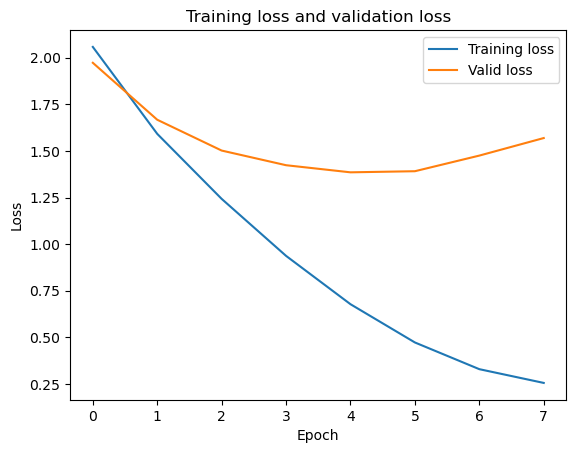

In [19]:
plt.plot(tl, label='Training loss')
plt.plot(vl, label='Valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss and validation loss')
plt.legend()

Training loss drops to around 0.25. Validation loss varies,ranging from 1.25 to 1.75.

Load the best state.

In [20]:
model.load_state_dict(torch.load('best.pt'))

<All keys matched successfully>

In [21]:
total = 0
correct = 0

for image, labels in test_loader:
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    for i in range(len(labels)):
        pred = predicted[i]
        total += 1
        if labels[i][pred] == 1:
            correct += 1
print('Accuracy', float(correct) / float(total))

Accuracy 0.6330275229357798


The accuracy of the neural network is better than the random forest, but it isn't too great. Accuracy tends to be between 50% and 66%.